# KNN + AE (Autoencoder)

In [1]:
# libraries
%matplotlib inline
from __future__ import print_function
from tensorflow.examples.tutorials.mnist import input_data
from sklearn import metrics, cross_validation
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
sess = tf.InteractiveSession()

In [2]:
# load MNIST data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

# placeholder for input data
x = tf.placeholder(tf.float32, [None, 784])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Autoencoder
- neurons: 25
- bias: true
- learning evaluation: Square Difference

In [3]:
new_dim = 40

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def modelEncode(X, w_h, w_b):
    return tf.add(tf.matmul(X, w_h), w_b)
    #return tf.nn.sigmoid(tf.add(tf.matmul(X, w_h), w_b))

def modelDecode(X, w_h, w_b):
    return tf.add(tf.matmul(X, w_h), w_b)
    #return tf.nn.relu(tf.add(tf.matmul(X, w_h), w_b))

w_h = init_weights([784, new_dim])

# Encode
encode_w_b = init_weights([new_dim])
encoded = modelEncode(x, w_h, encode_w_b)

# Decode
decode_w_b = init_weights([784])
decoded = modelDecode(encoded, tf.transpose(w_h), decode_w_b)

# Square Difference
sq_diff = tf.mul(tf.reduce_mean(tf.square(x - decoded)), 0.5)

### Gradient Descent Optimizer:

In [4]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(sq_diff)

### Training:
- training steps: 15000
- step: 100 samples

Time: 45.62 sec

Final reconstruction error (square difference): 0.0072



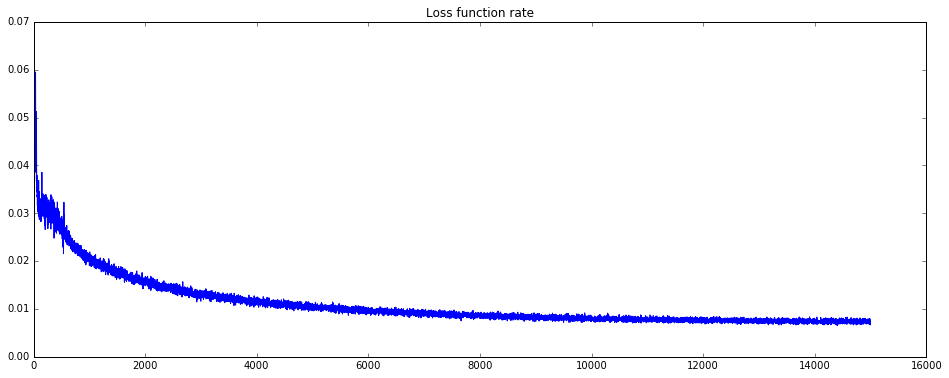

In [5]:
# initialize variables
sess.run(tf.initialize_all_variables())

# train
sq_diff_acum = []
start_time = timeit.default_timer()
for i in range(15000):
  batch_xs, _ = mnist.train.next_batch(100)
  sqd, _ = sess.run([sq_diff, train_step], feed_dict={x:batch_xs})
  sq_diff_acum.append(sqd) 
elapsed = timeit.default_timer() - start_time
print("Time: %.2f sec" % elapsed)

# results
print("\nFinal reconstruction error (square difference): %.4f" % sq_diff.eval(feed_dict={x: mnist.test.images}))
print()
plt.figure(figsize=(16, 6))
plt.title("Loss function rate")
plt.plot(sq_diff_acum)
plt.show()

### Image Reconstruction Test

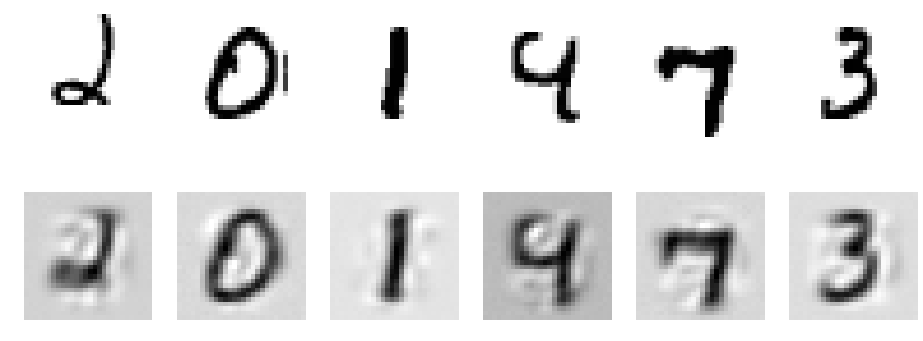

In [6]:
choice = np.random.choice(range(len(range(55000))), 6, replace=False)
real = mnist.train.images[choice]
reconstructed = decoded.eval(feed_dict={x: real})

plt.figure(figsize=(16, 6))
for index, i in enumerate(choice):
    plt.subplot(2, 6, index+1)
    plt.axis('off')
    plt.imshow(real[index].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(2, 6, index+1+6)
    plt.axis('off')
    plt.imshow(reconstructed[index].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')

### Transform data (train and test)

In [7]:
train_ext = tf.matmul(x, w_h).eval(feed_dict={x: mnist.train.images})
test_ext = tf.matmul(x, w_h).eval(feed_dict={x: mnist.test.images})
y_train = mnist.train.labels 
y_test = mnist.test.labels

### KNN: n_neighbors: 5

In [8]:
knn = KNeighborsClassifier(weights='distance')
start_time = timeit.default_timer()
knn.fit(train_ext, y_train)
elapsed = timeit.default_timer() - start_time
print("KNN fit time: %.2f sec" % (elapsed))

KNN fit time: 0.22 sec


Make predictions on test data

In [9]:
start_time = timeit.default_timer()
predicted = knn.predict(test_ext)
elapsedPredict = timeit.default_timer() - start_time
print("KNN predict time: %.2f sec" % (elapsedPredict))

KNN predict time: 48.95 sec


### Cross Validation: Folds: 5

In [15]:
start_time = timeit.default_timer()
scores = cross_validation.cross_val_score(knn, train_ext, y_train, cv=5, n_jobs=-1)
elapsedCV = timeit.default_timer() - start_time
print("Cross validatione time: %.2f sec" % (elapsedCV))
np.set_printoptions(precision=4)
print("Cross validation scores:", scores)
print("Cross validation mean: %0.3f (+/-%0.03f)" % (scores.mean(), scores.std() * 2))

Cross validatione time: 97.60 sec
Cross validation scores: [ 0.9769  0.9784  0.9754  0.9731  0.9769]
Cross validation mean: 0.976 (+/-0.004)


### Classification metrics

In [10]:
print("\nAccuracy on test data: %.4f" % metrics.accuracy_score(y_test, predicted))


Accuracy on test data: 0.9762


#### Confusion matrix:

In [11]:
print(metrics.confusion_matrix(y_test, predicted, range(10)))

[[ 974    1    1    0    0    1    2    1    0    0]
 [   0 1131    3    0    0    0    0    0    0    1]
 [   5    0 1007    0    1    0    4   11    4    0]
 [   0    0    2  975    1   13    0    7    8    4]
 [   1    0    0    0  953    0    7    2    1   18]
 [   3    0    0   11    0  868    4    1    0    5]
 [   2    4    0    0    3    2  946    0    1    0]
 [   0   17    5    1    2    0    0  993    0   10]
 [   4    0    4   11    2    6    2    3  938    4]
 [   3    3    1    6    5    4    1    7    2  977]]


#### Classification report:
- precision: truePositives / (truePositives + falsePositives)
- recall: truePositives / Positives
- f1-score: 2 * (precision * recall) / (precision + recall)
- support: Cantidad de ocurrencias

In [12]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       980
          1       0.98      1.00      0.99      1135
          2       0.98      0.98      0.98      1032
          3       0.97      0.97      0.97      1010
          4       0.99      0.97      0.98       982
          5       0.97      0.97      0.97       892
          6       0.98      0.99      0.98       958
          7       0.97      0.97      0.97      1028
          8       0.98      0.96      0.97       974
          9       0.96      0.97      0.96      1009

avg / total       0.98      0.98      0.98     10000



### Error samples:

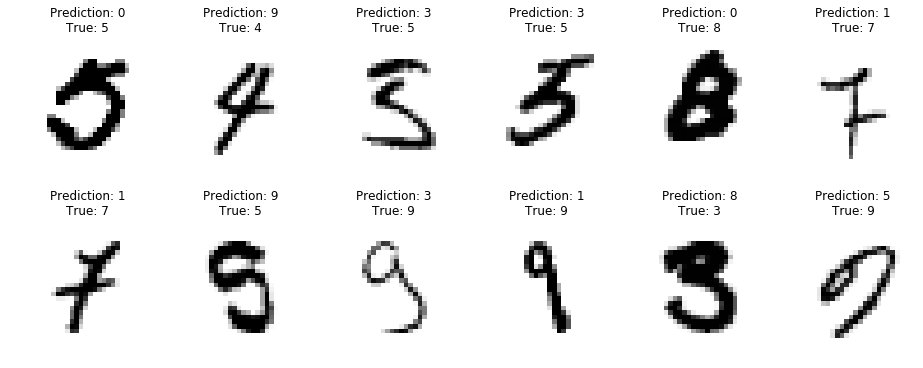

In [13]:
misslabels = predicted[y_test != predicted]
reallabels = y_test[y_test != predicted]
missimages = mnist.test.images[y_test != predicted]
choice = np.random.choice(range(len(misslabels)), 12, replace=False)
plt.figure(figsize=(16, 6))
for index, i in enumerate(choice):
    plt.subplot(2, 6, index+1)
    plt.axis('off')
    plt.imshow(missimages[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i\nTrue: %i' % (misslabels[i], reallabels[i]))

Save results:

In [20]:
df = pd.DataFrame(metrics.confusion_matrix(y_test, predicted, range(10)))
df.to_csv('knnAutoenconderAndWeights.csv')
with open('knnAutoenconderAndWeightsTime.txt', 'w') as file_:
    file_.write('%.4f' % elapsed)
dfResults = pd.DataFrame(predicted)
dfResults.to_csv('knnAutoenconderAndWeightsResults.csv')